Ce notebook va être consacré au preprocessing du dataset et l'entrainement d'un premier modèle simple pour établir une baseline.

---

# Load

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

years = range(2019, 2023)

In [2]:
data = pd.DataFrame()

for year in years:
    path = os.path.join(base_path, str(year), file_name)
    year_csv = pd.read_csv(
            path,
            dtype=type_dict,
    )
    data = pd.concat([
        data,
        year_csv
    ]).reset_index(drop=True)

# Preprocessing

In [3]:
## Rainfall -------------------------------------------------------------------

def process_rainfall(df): # Removes races with rain
    rain = df.groupby(['Year', 'RoundNumber', 'DriverNumber'])['Compound'].transform(lambda x: x[x.str.contains('INTERMEDIATE|WET')].count())
    return df[rain == 0].reset_index(drop=True)

## TrackName ------------------------------------------------------------------

def process_track_name(df):
    df['Track'] = df['Track'].str.replace(' ', '_')
    return df
## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': -1,
        'GapToLeader': -1,
        'IntervalToPositionAhead': -1,
    }, inplace=True)

    # drop all rows with missing laptime
    df.dropna(subset=['LapTime'], inplace=True)
    return df[df['LapNumber'] > 1].reset_index(drop=True)

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    #df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    #df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate', 'Year', 'RoundNumber'], axis=1, inplace=True)
    return df

## Feature encoding ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

def process_feature_encoding(df):
    categorical_features = ['Compound', 'Track']
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    one_hot_encoder.fit(df[categorical_features])
    one_hot_encoded = one_hot_encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    print("One hot : ", one_hot_encoded.shape)
    print("Data : ", df.shape)
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df, one_hot_encoder

def process_feature_encoding_new(df, encoder):
    categorical_features = ['Compound', 'Track']
    one_hot_encoded = encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df

In [4]:
def preprocess_pre_split(df):
    df = df.copy()
    print('Preprocessing data...', df.shape)
    df = process_rainfall(df)
    print('Rainfall processed...', df.shape)
    df = process_track_name(df)
    print('TrackName processed...', df.shape)
    df = process_missing_values(df)
    print('Missing values processed...', df.shape)
    return df

def preprocess_post_split(df):
    df = process_trackStatus(df)
    print('TrackStatus processed...', df.shape)
    df = process_datatypes(df)
    print('Preprocessing data...', df.shape)
    df = process_remove_features(df)
    print('Features removed...', df.shape)
    return df

def preprocess_post_split_train(df):
    df = df.copy()
    df = process_target(df)
    print('Target processed...', df.shape)
    df, encoder = process_feature_encoding(df)
    print('Features encoded...', df.shape)

    df = preprocess_post_split(df)
    
    return df, encoder

def preprocess_post_split_test(df, encoder):
    df = df.copy()
    df = process_target(df)
    print('Target processed...', df.shape)
    df = process_feature_encoding_new(df, encoder)
    print('Features encoded...', df.shape)

    df = preprocess_post_split(df)

    return df

In [5]:
#%pip install imblearn

In [6]:
def get_races_grouped(df):
    return df.groupby(['Year', 'RoundNumber', 'DriverNumber'])

def get_train_test_split(df, test_size, return_groups=False):
    groups = get_races_grouped(df).groups
    groups_keys = list(groups.keys())
    np.random.shuffle(groups_keys)
    test_groups = groups_keys[:int(len(groups_keys) * test_size)]
    train_groups = groups_keys[int(len(groups_keys) * test_size):]
    test = df[df.apply(lambda x: (x['Year'], x['RoundNumber'], x['DriverNumber']) in test_groups, axis=1)].reset_index(drop=True)
    train = df[df.apply(lambda x: (x['Year'], x['RoundNumber'], x['DriverNumber']) in train_groups, axis=1)].reset_index(drop=True)
    if return_groups:
        return train, test, train.groupby(['Year', 'RoundNumber', 'DriverNumber']).groups, test.groupby(['Year', 'RoundNumber', 'DriverNumber']).groups
    return train, test

In [7]:
df = data.copy()
df = preprocess_pre_split(df)

Preprocessing data... (89139, 29)
Rainfall processed... (78346, 29)
TrackName processed... (78346, 29)
Missing values processed... (75663, 29)


In [8]:
train_df, test_df, train_groups, test_groups = get_train_test_split(df.copy(), test_size=0.2, return_groups=True)

In [9]:
train_df, encoder = preprocess_post_split_train(train_df)
test_df = preprocess_post_split_test(test_df, encoder)

Target processed... (60505, 30)
One hot :  (60505, 32)
Data :  (60505, 30)
Features encoded... (60505, 60)
TrackStatus processed... (60505, 65)
Preprocessing data... (60505, 65)
Features removed... (60505, 50)
Target processed... (15158, 30)
Features encoded... (15158, 60)
TrackStatus processed... (15158, 65)
Preprocessing data... (15158, 65)
Features removed... (15158, 50)


In [10]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

X_train = train_df.drop(['is_pitting'], axis=1)
y_train = train_df['is_pitting']

X_test = test_df.drop(['is_pitting'], axis=1)
y_test = test_df['is_pitting']

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60505, 49) (15158, 49) (60505,) (15158,)


# Modelisation

In [12]:
def calculate_distance_to_next_true(series):
    # Find the indices of True values
    true_indices = np.where(series)[0]
    true_indices = np.concatenate((true_indices, [len(series)]))

    distance_to_next_true = np.zeros(len(series))
    for i in range(len(series)):
        sorted_indices = np.searchsorted(true_indices, i)
        if sorted_indices == len(true_indices) - 1:
            distance_to_next_true[i] = len(series)
        else:
            distance_to_next_true[i] = true_indices[sorted_indices] - i

    # Replace the True values by the distance to the next True value
    result_series = pd.Series(distance_to_next_true)
    
    return result_series

def calculate_weight(proba, distance_to_pit, threshold=0.5, penalty=1):
    if distance_to_pit <= 0:
        return proba
    elif proba >= threshold:
        #return distance_to_pit * (1 - (1 + penalty) * proba)
        return distance_to_pit * penalty * -(-proba + threshold)**2
    else:
        return 0
    
def calculate_weights(preds):
    distances = calculate_distance_to_next_true(preds['y'])
    weights = []
    for i in range(len(preds['y'])):
        weights.append(calculate_weight(preds['proba'][i], distances[i], penalty=0.5))
    return weights

def plot_remove_duplicate_legends(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), **kwargs)
    return ax

def plot_weights(ax, weights):
    ax.grid(True)
    weights_cumsum = np.cumsum(weights)
    ax.plot(weights_cumsum)
    ax.set_autoscaley_on(True)
    return plot_remove_duplicate_legends(ax)

In [13]:
from tensorflow import keras
class RacePerformanceMetricCallback(keras.callbacks.Callback):
    def __init__(self, x_val, y_val, groups, threshold=0.5, penalty=0.5, verbose=1):
        super(RacePerformanceMetricCallback, self).__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.threshold = threshold
        self.penalty = penalty
        self.groups = groups
        self.score_history = []
        self.verbose = verbose
    def on_train_begin(self, logs=None):
        self.score_history = []
    def on_epoch_end(self, epoch, logs=None):
        average_score = 0
        for group, laps in self.groups.items(): # Make preds for each race separately
            preds = self.model.predict(self.x_val[laps], verbose=self.verbose)
            preds = pd.DataFrame(preds, columns=['proba'])
            preds['y'] = self.y_val[laps]
            weights = calculate_weights(preds)
            average_score += np.sum(weights)
        average_score /= len(self.groups)
        self.score_history.append(average_score)
    def on_train_end(self, logs=None):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        plot_score_history(ax, self.score_history)
        plt.show()
        self.model = None

def plot_score_history(ax, score_history):
    ax.grid(True)
    ax.plot(score_history)
    ax.set_autoscaley_on(True)
    return plot_remove_duplicate_legends(ax)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix

import tensorflow.keras.backend as K

def balanced_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return (specificity + sensitivity) / 2

def balanced_accuracy_loss(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    specificity = tn / (tn + fp + K.epsilon())
    sensitivity = tp / (tp + fn + K.epsilon())
    return (specificity + sensitivity) / 2

In [15]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [16]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weights = dict(enumerate(class_weights))

class_weights

{0: 0.5146295823764566, 1: 17.588662790697676}

In [17]:
racePerformanceCallback = RacePerformanceMetricCallback(X_test, y_test, test_groups, verbose=0)


param_grid = {
    'batch_size': [1024, 512, 256],
    'epochs': [100],
    'verbose': [0],
    'callbacks': [[racePerformanceCallback]],
    'class_weight': [class_weights],
    'layers': [[1024, 512, 256, 64, 32], [512, 256, 128, 64, 32], [256, 128, 64, 32, 16], [128, 64, 32, 16, 8], [1024, 256, 32], [512, 128, 16], [256, 64, 8], [128, 32, 4], [64, 16, 2], [32, 8, 1]],
    'dropout': [[0.4, 0.3, 0.2, 0, 0], [0.3, 0.2, 0.1, 0, 0], [0.2, 0.1, 0.05, 0, 0], [0.1, 0.05, 0.025, 0, 0], [0.4, 0.2, 0, 0, 0], [0.3, 0.1, 0, 0, 0], [0.2, 0.05, 0, 0, 0], [0.1, 0.025, 0, 0, 0], [0.05, 0.0125, 0, 0, 0], [0.4, 0, 0, 0, 0], [0.3, 0, 0, 0, 0], [0.2, 0, 0, 0, 0], [0.1, 0, 0, 0, 0], [0.05, 0, 0, 0, 0], [0.025, 0, 0, 0, 0]],
    'learning_rate': [0.0005, 0.0001],
}

smaller_param_grid = {
    'batch_size': [1024, 512, 256],
    'epochs': [100],
    'verbose': [0],
    'callbacks': [[racePerformanceCallback]],
    'class_weight': [class_weights],
    'layers': [[256, 128, 64, 32, 16], [128, 64, 32, 16, 8], [64, 16, 2], [32, 8, 1]],
    'dropout': [[0.4, 0.3, 0.2, 0, 0], [0.05, 0, 0, 0, 0], [0.025, 0, 0, 0, 0]],
    'learning_rate': [0.0005, 0.0001],
}

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam

def create_model(layers_param, dropout_param, learning_rate_param):
    input_dim = X_train.shape[1]
    # Create model
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for i in range(len(layers_param)):
        model.add(layers.Dense(layers_param[i], activation='relu'))
        if len(dropout_param) > i and dropout_param[i] > 0:
            model.add(layers.Dropout(dropout_param[i]))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = Adam(
        learning_rate=learning_rate_param,
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[balanced_accuracy_loss],
        )
    
    return model

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0005, 'verbose': 0}


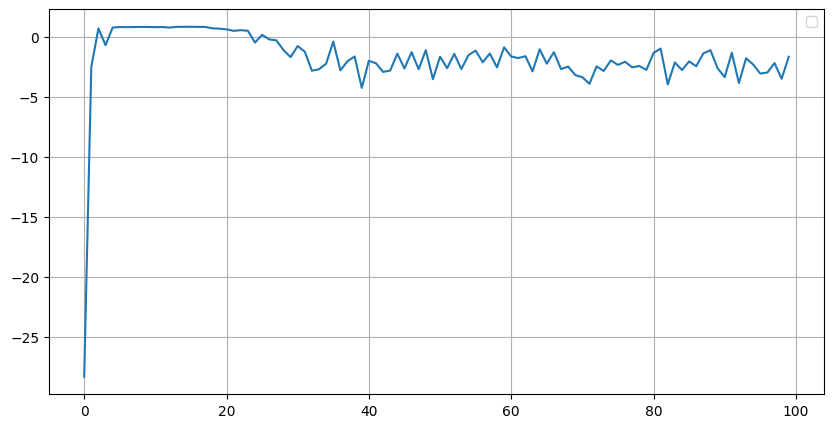

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


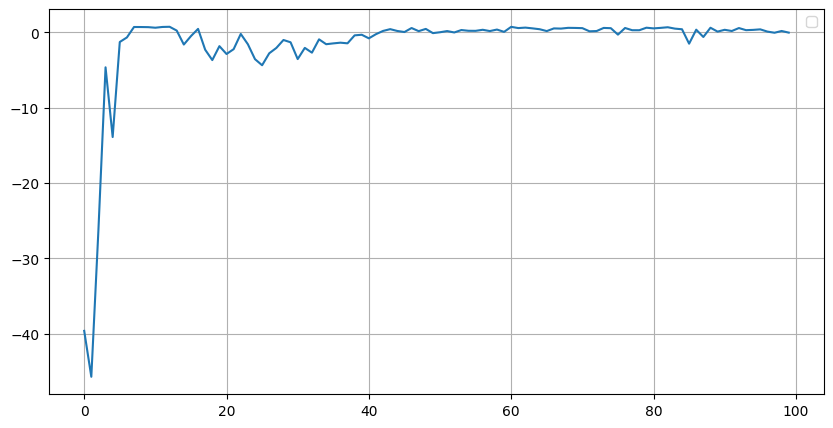

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0005, 'verbose': 0}


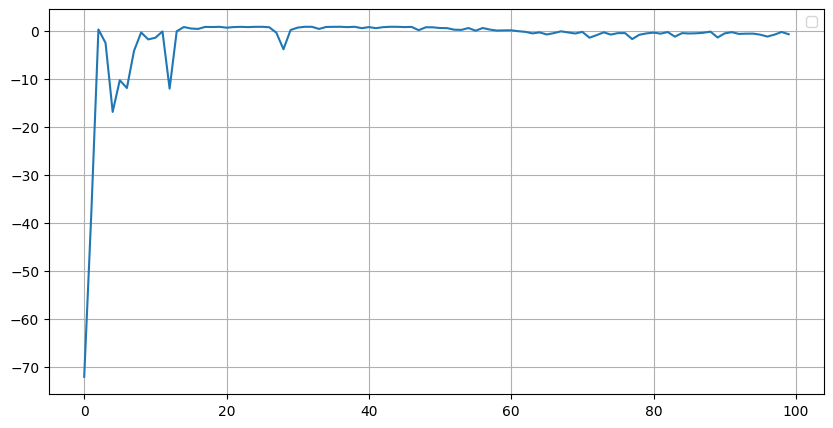

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0001, 'verbose': 0}


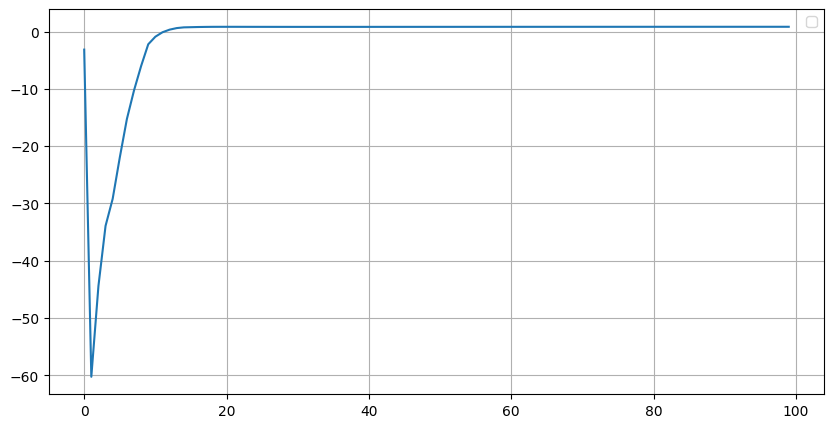

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}


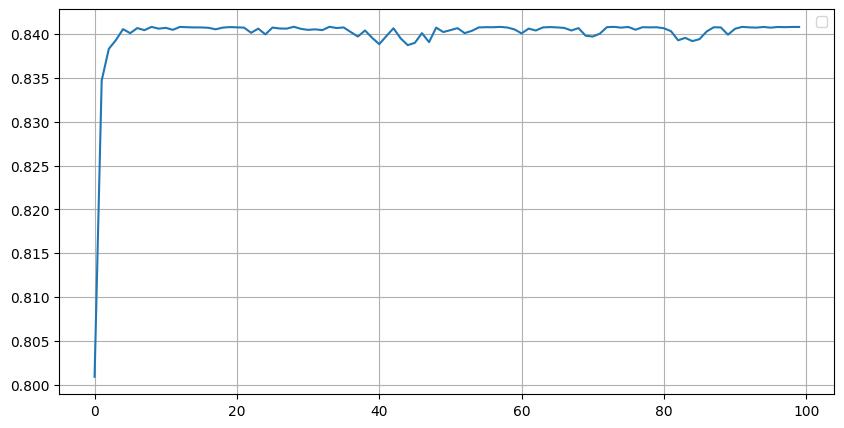

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}


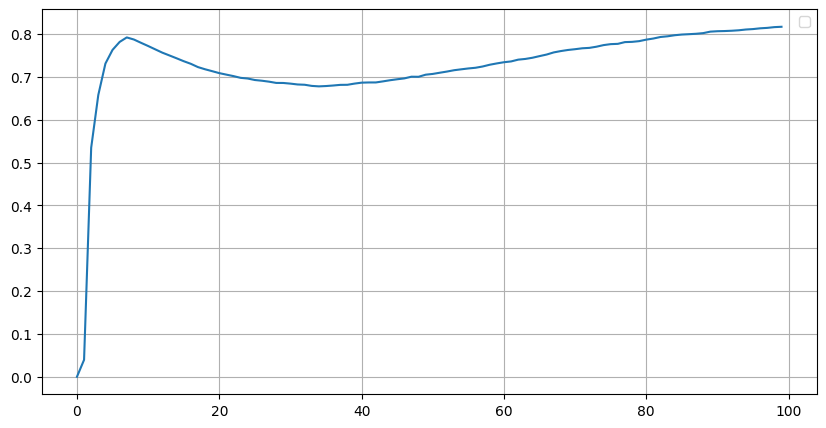

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}


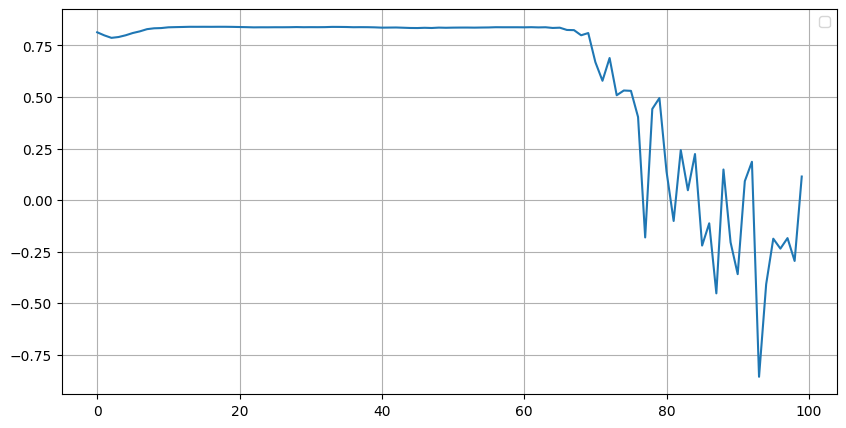

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0001, 'verbose': 0}


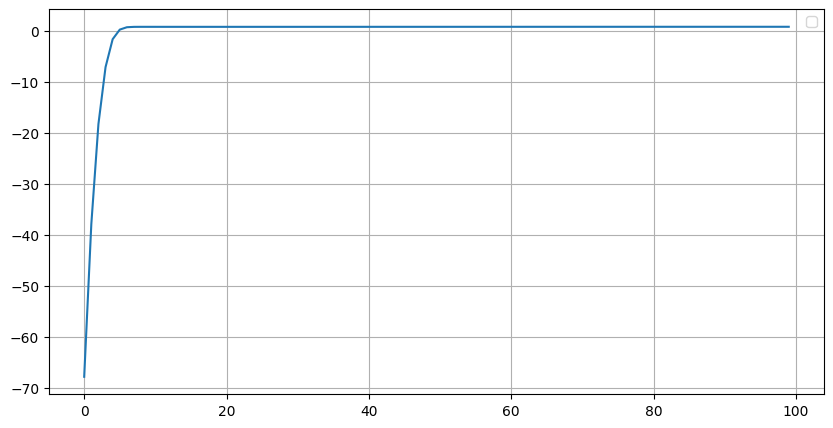

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0005, 'verbose': 0}


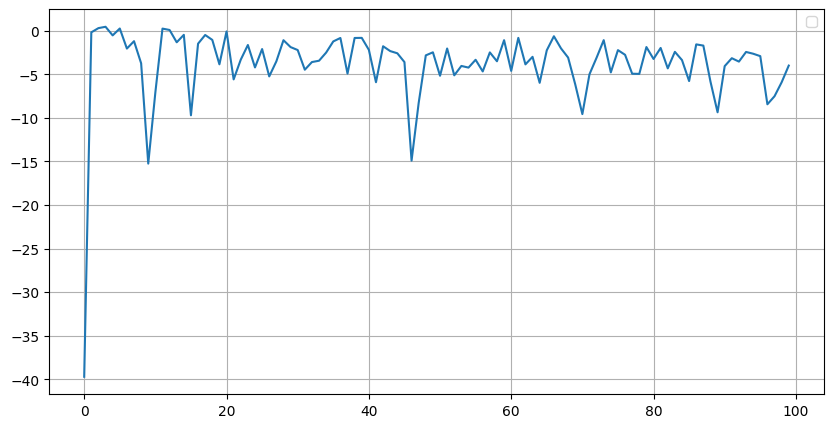

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


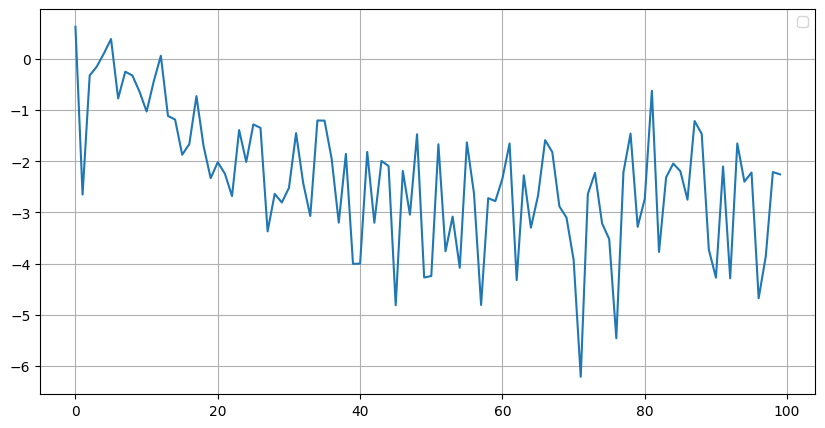

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0005, 'verbose': 0}


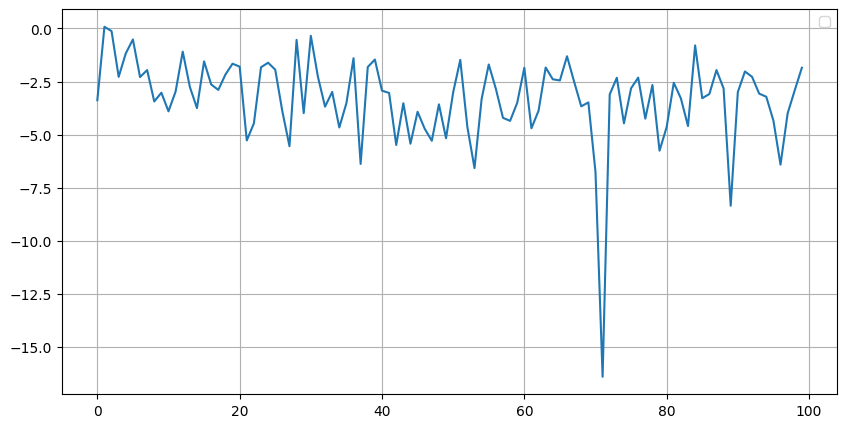

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0001, 'verbose': 0}


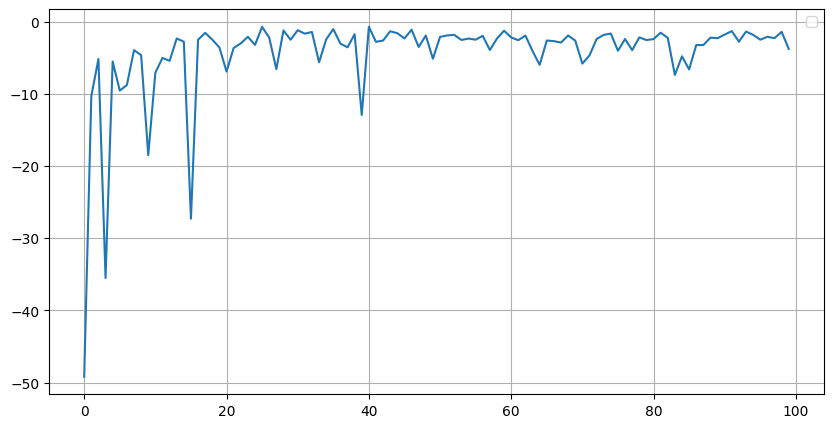

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}


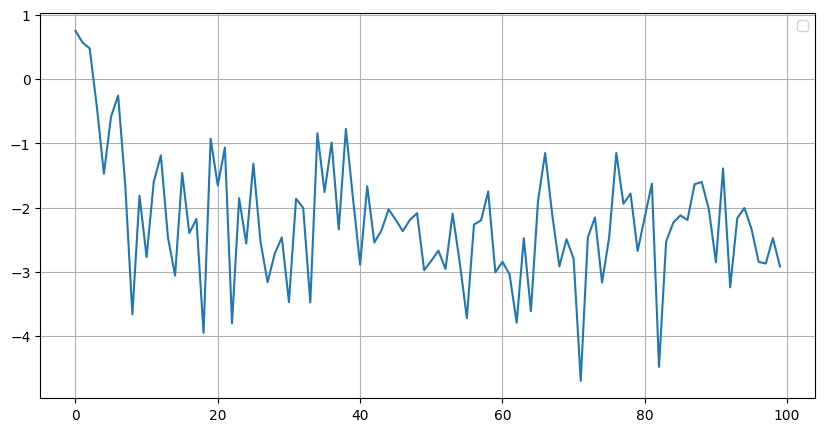

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}


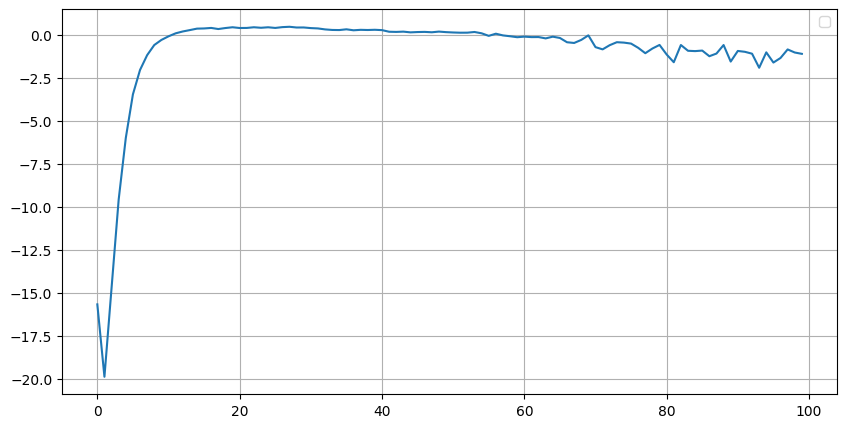

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}


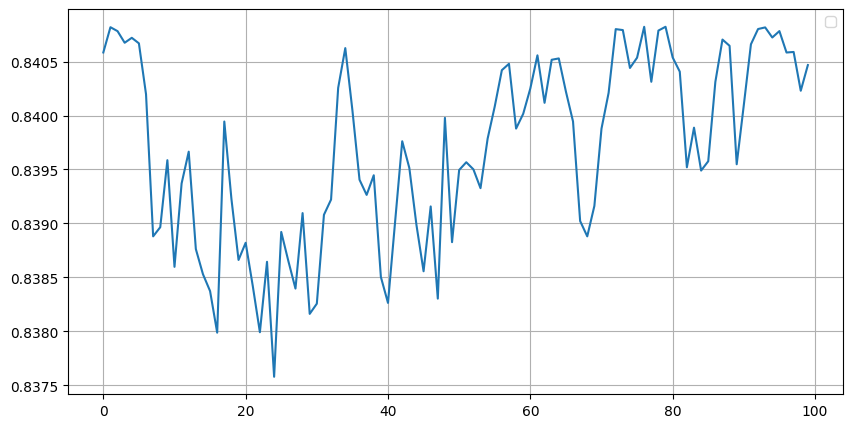

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0001, 'verbose': 0}


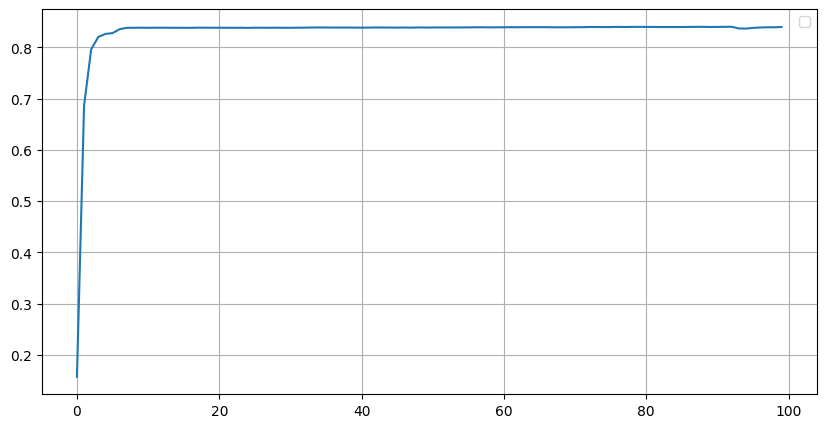

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0005, 'verbose': 0}


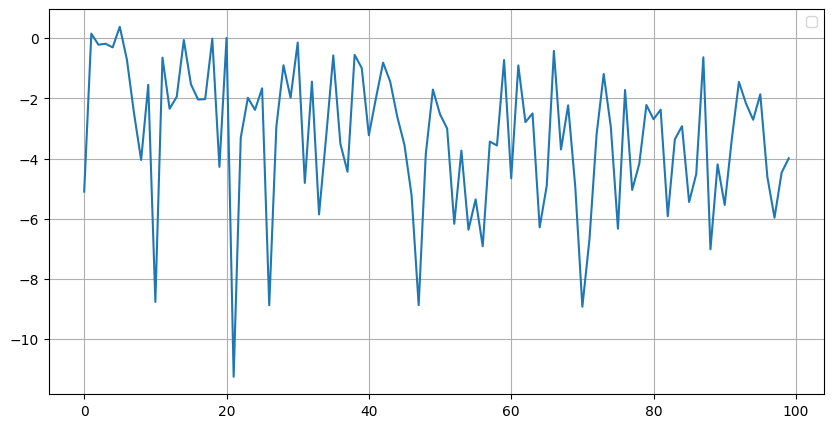

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


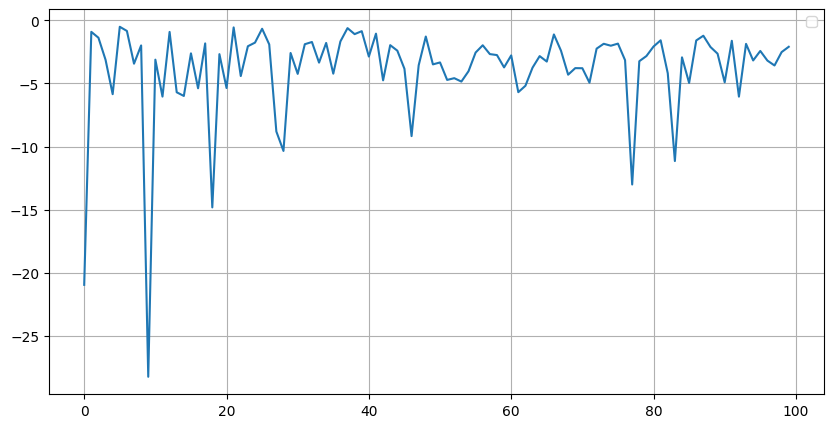

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0005, 'verbose': 0}


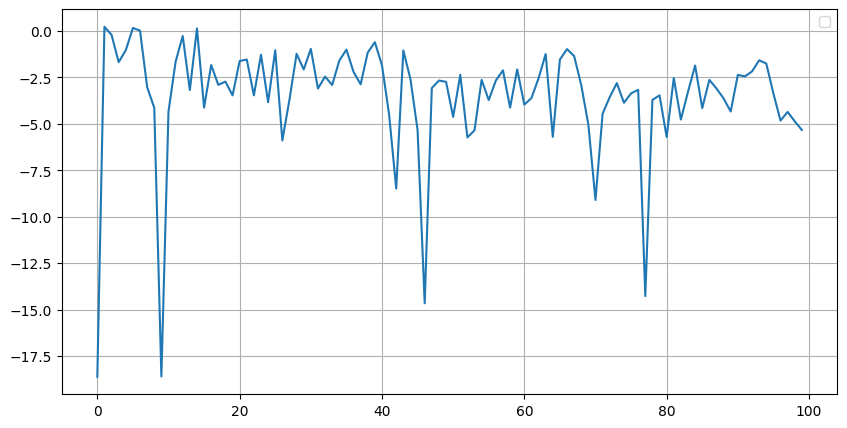

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0001, 'verbose': 0}


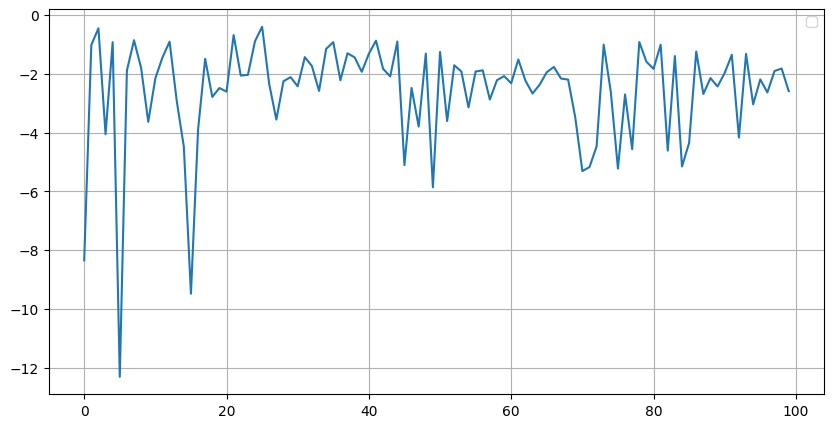

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}


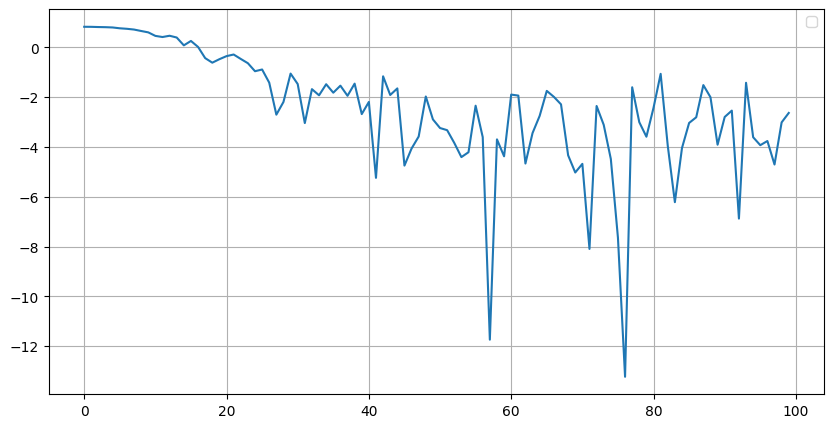

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}


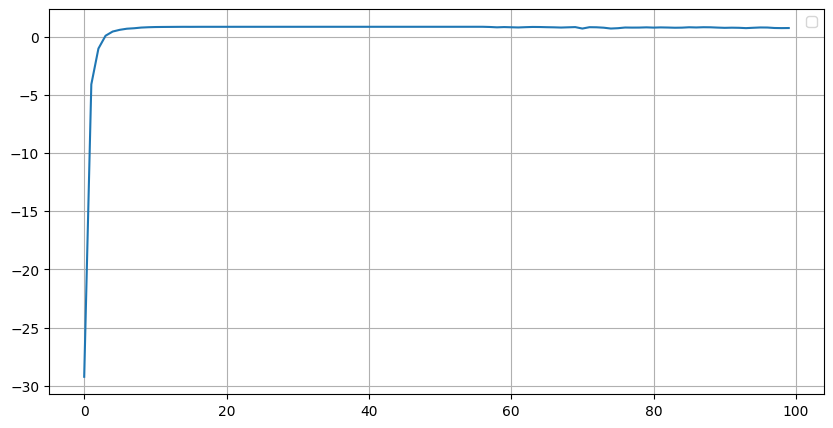

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}


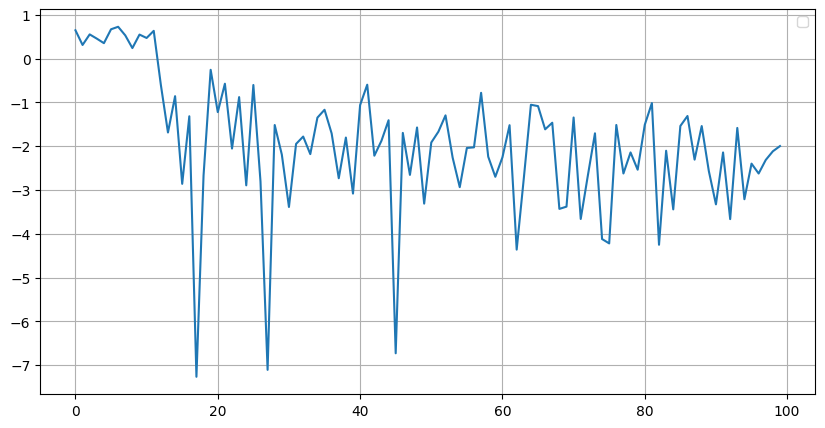

{'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0001, 'verbose': 0}


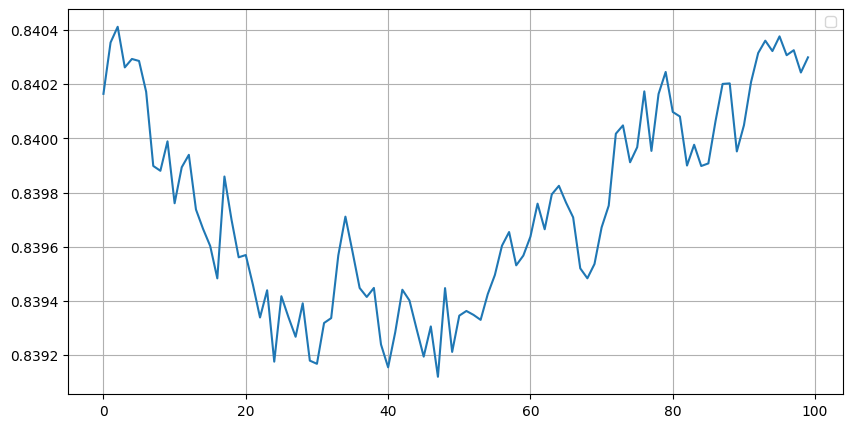

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0005, 'verbose': 0}


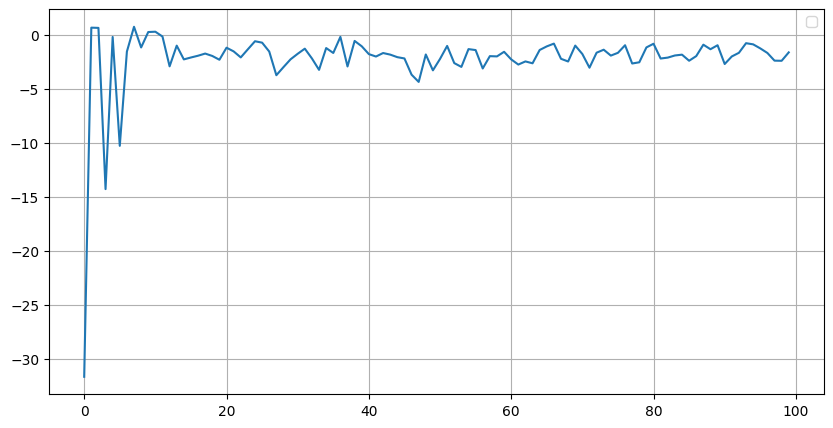

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


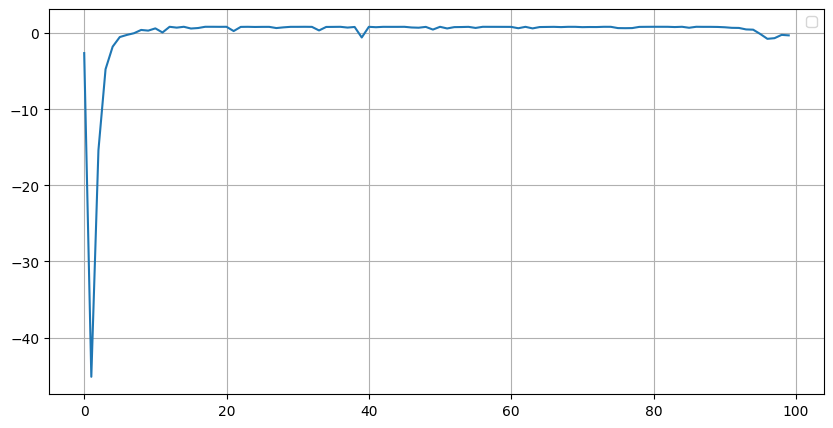

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0005, 'verbose': 0}


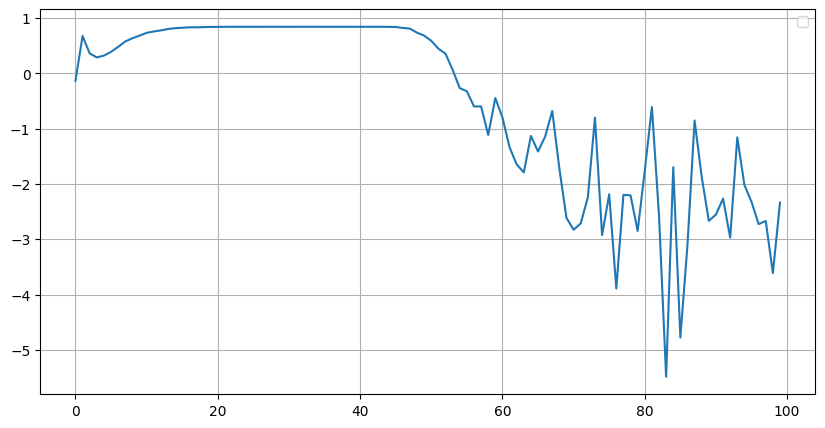

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0001, 'verbose': 0}


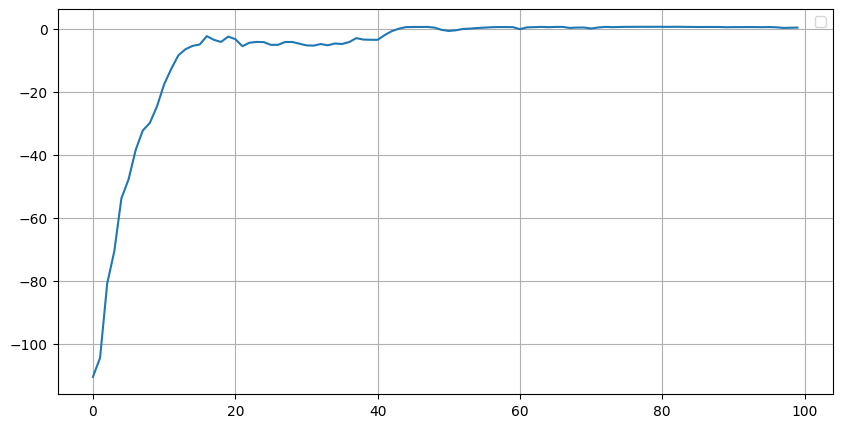

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}


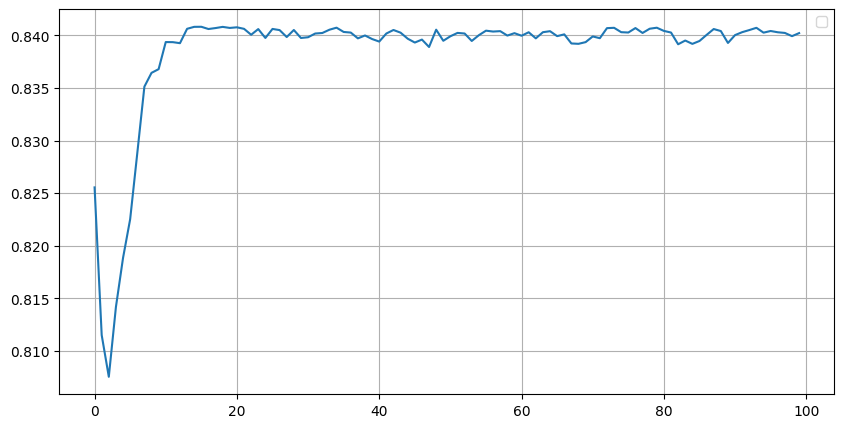

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}


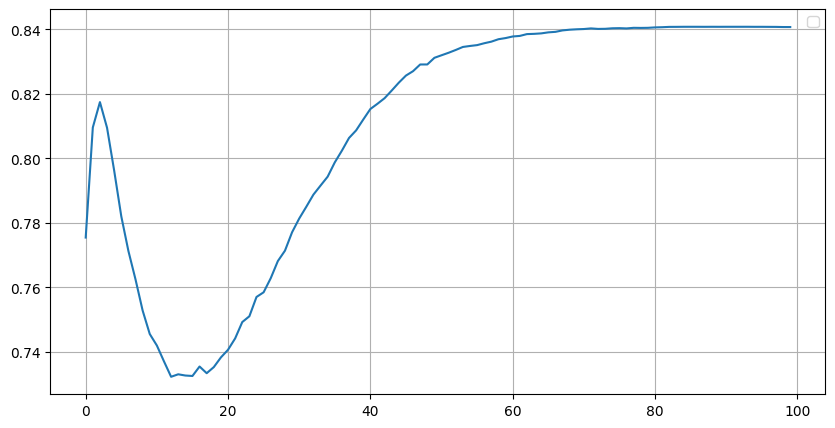

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}


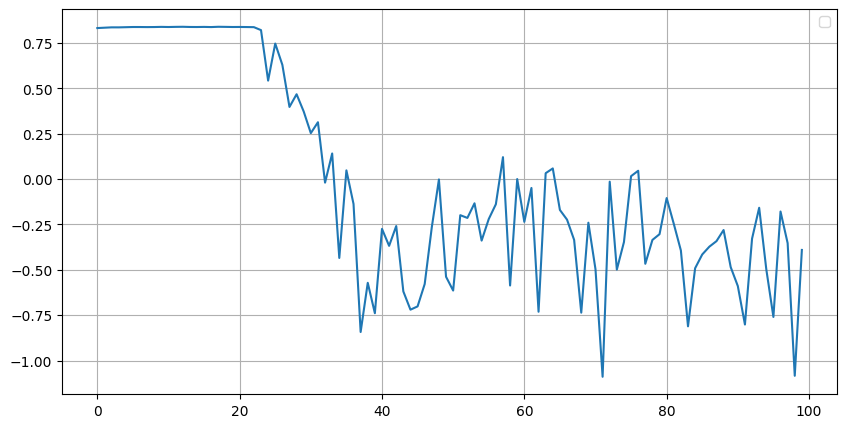

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0001, 'verbose': 0}


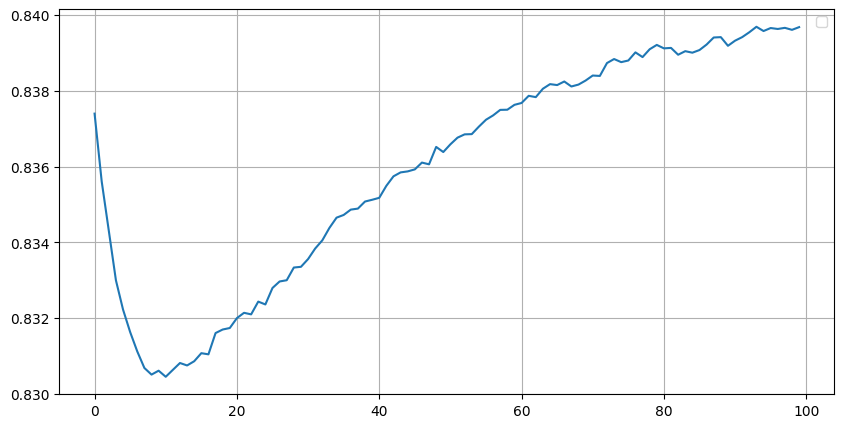

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0005, 'verbose': 0}


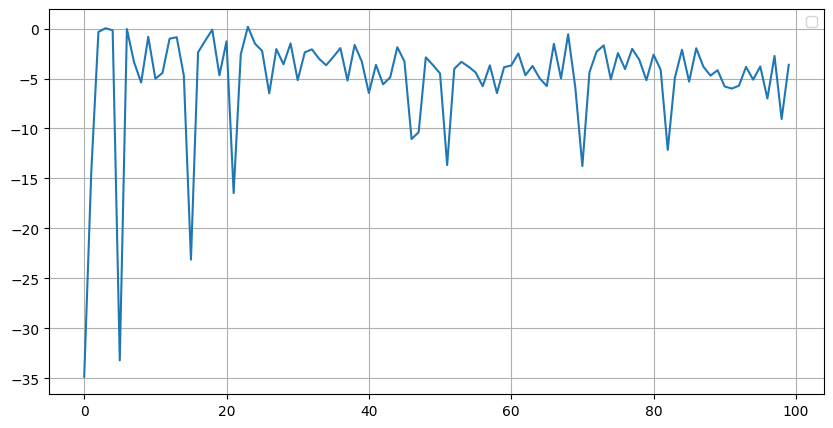

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


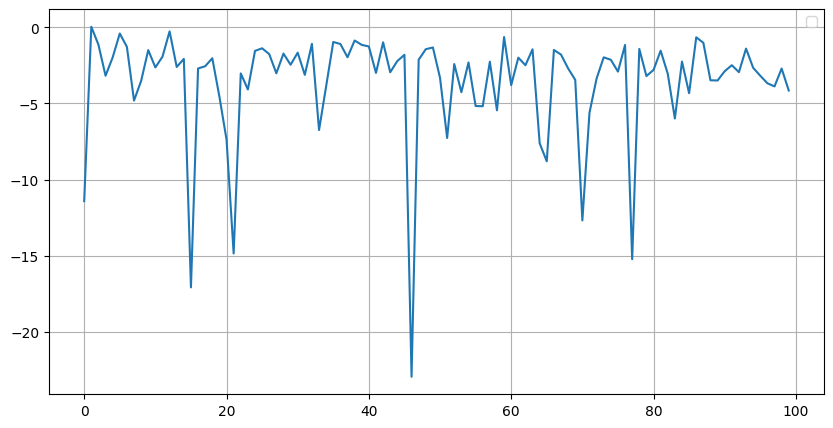

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0005, 'verbose': 0}


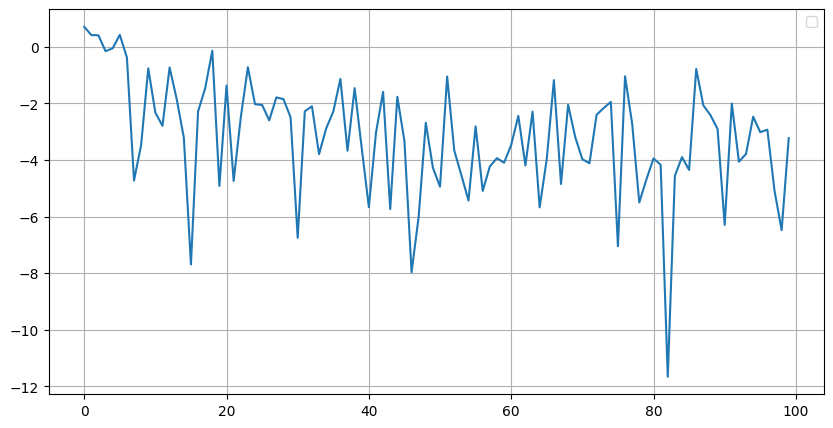

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0001, 'verbose': 0}


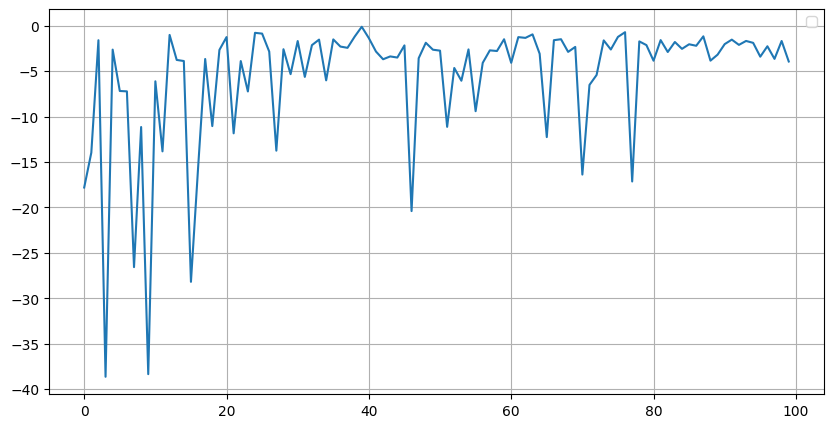

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}


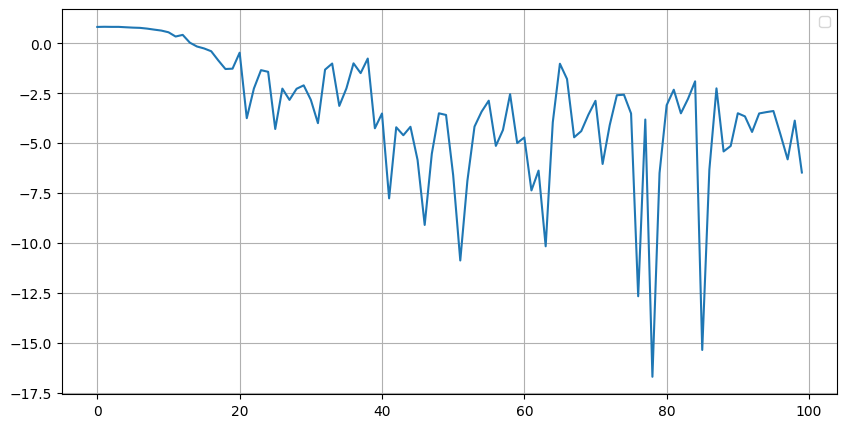

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}


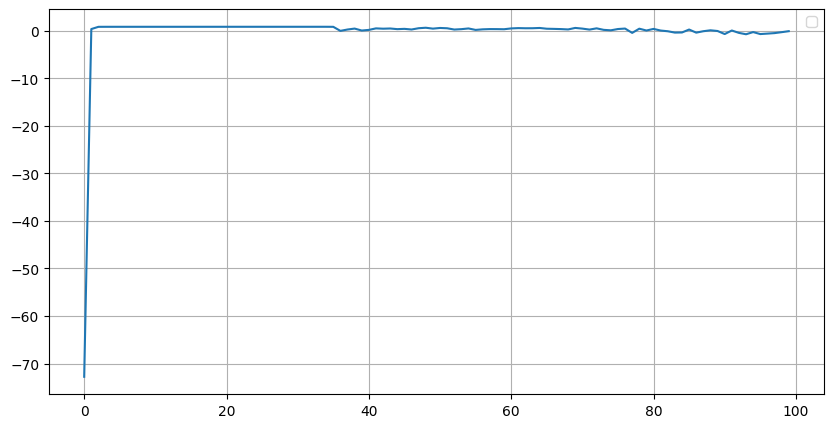

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}


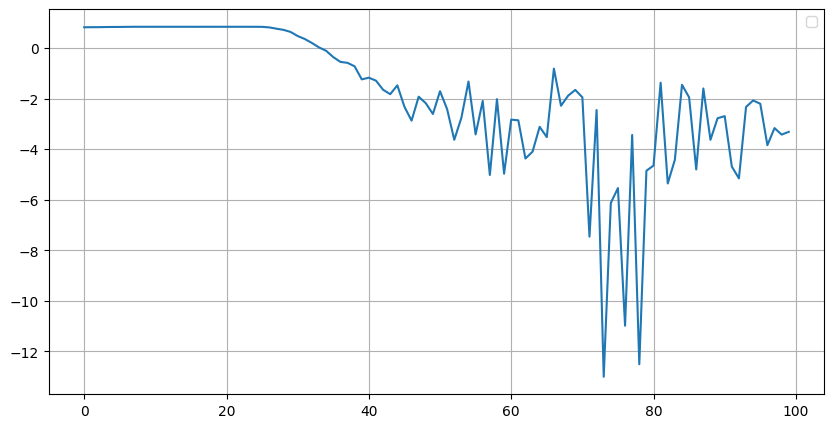

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0001, 'verbose': 0}


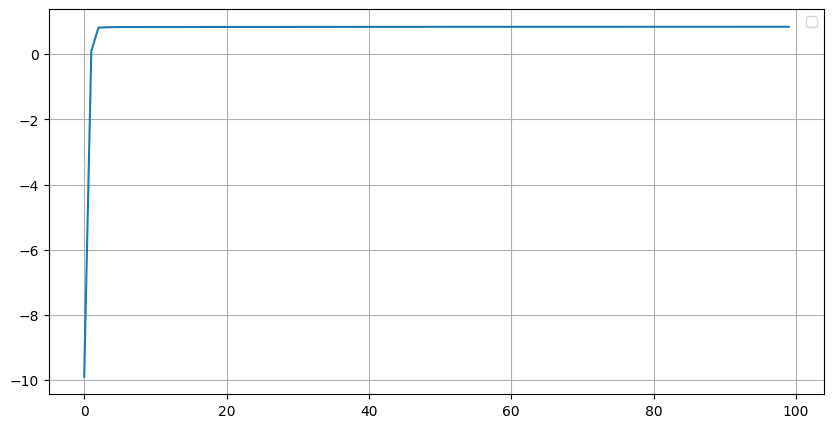

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0005, 'verbose': 0}


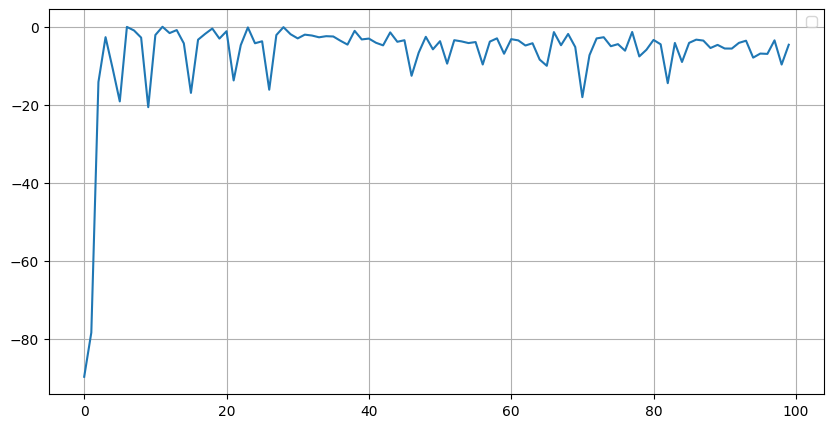

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


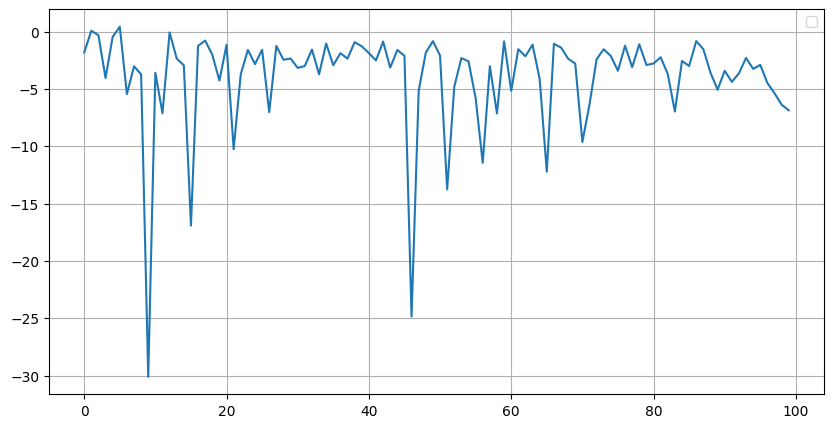

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0005, 'verbose': 0}


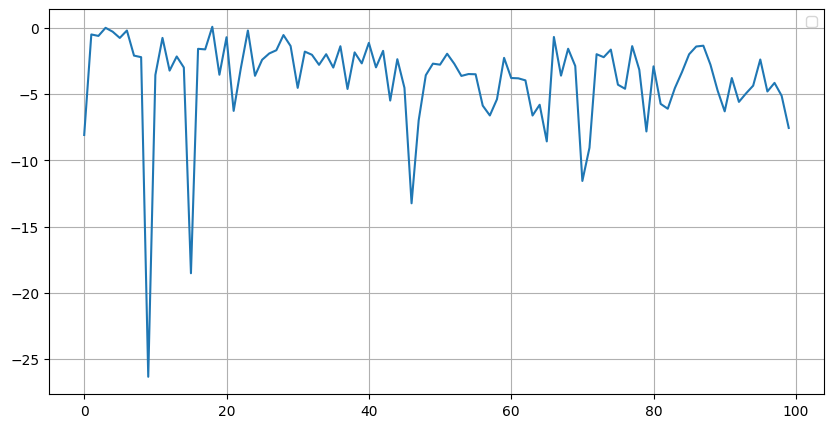

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0001, 'verbose': 0}


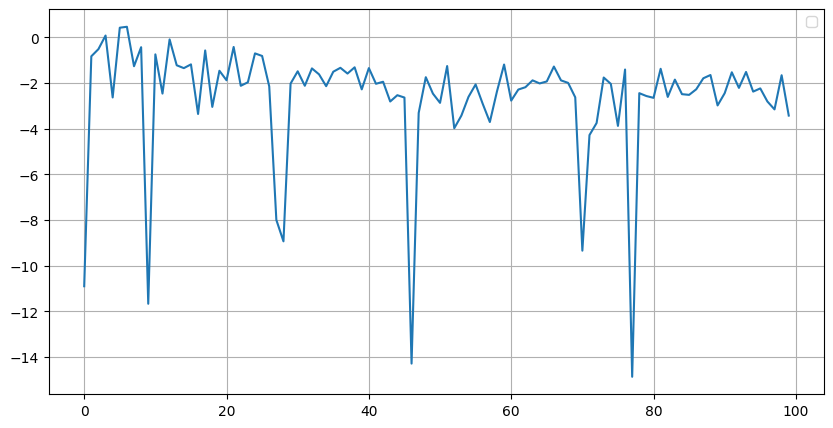

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}


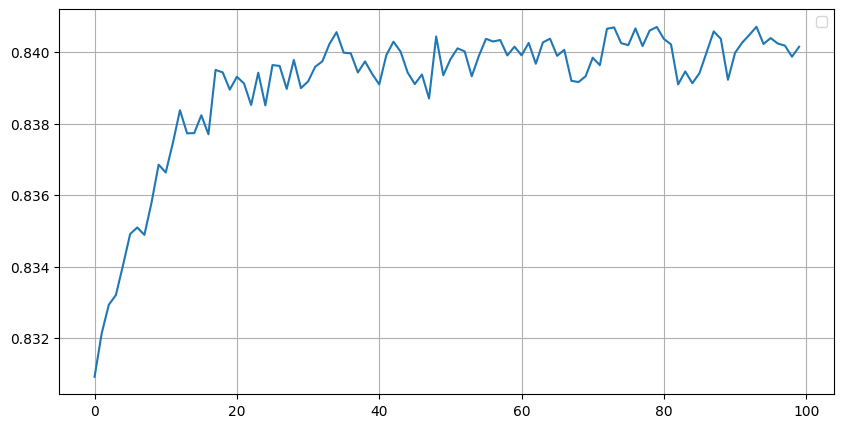

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}


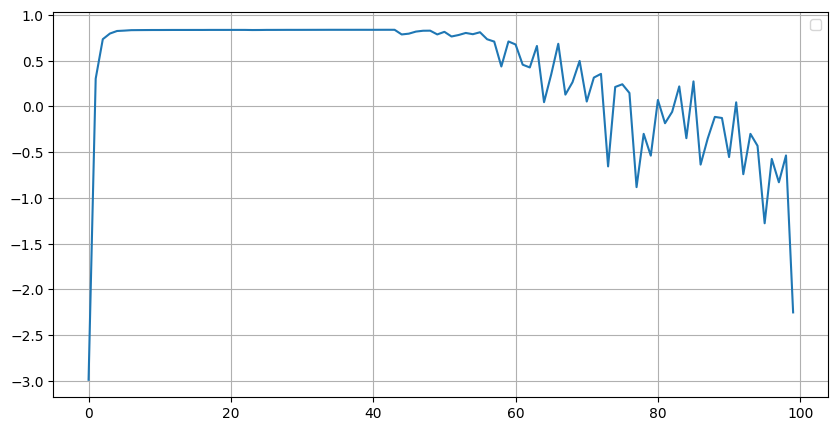

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}


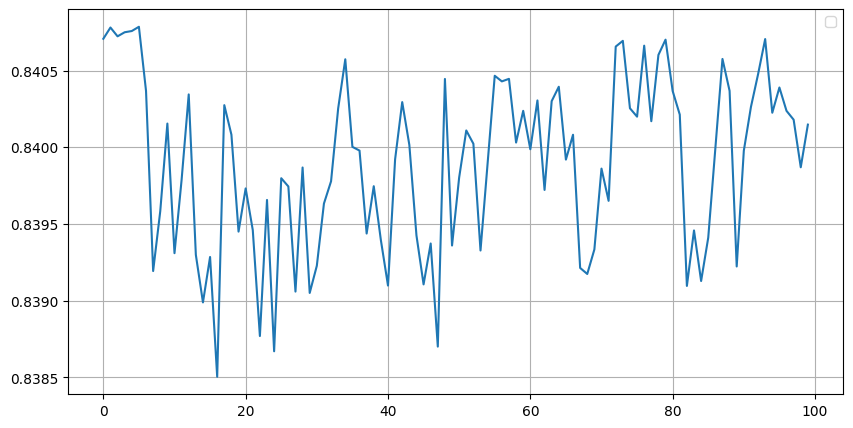

{'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0001, 'verbose': 0}


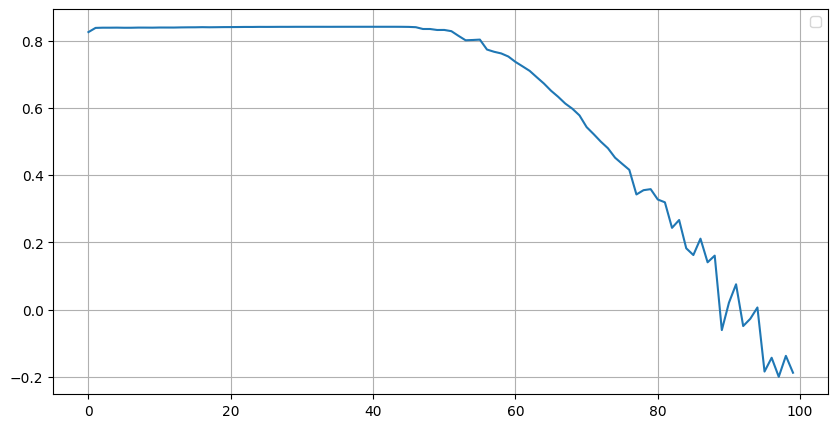

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0005, 'verbose': 0}


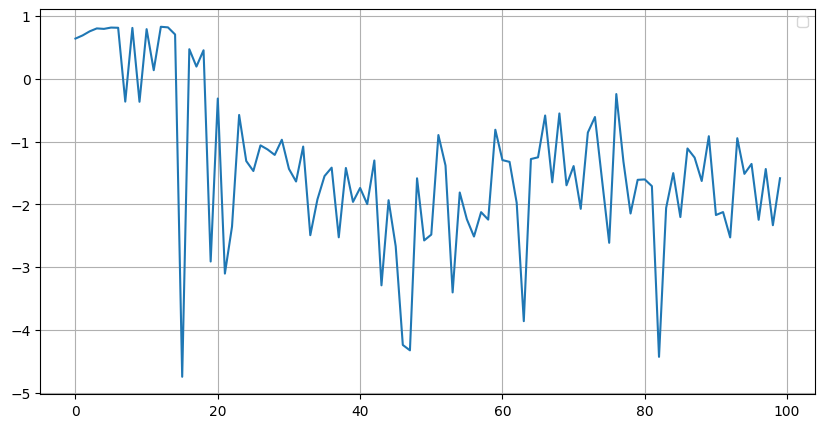

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


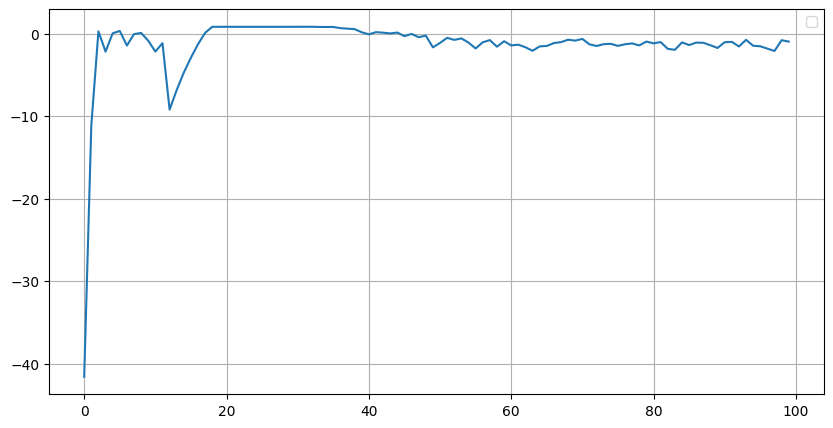

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0005, 'verbose': 0}


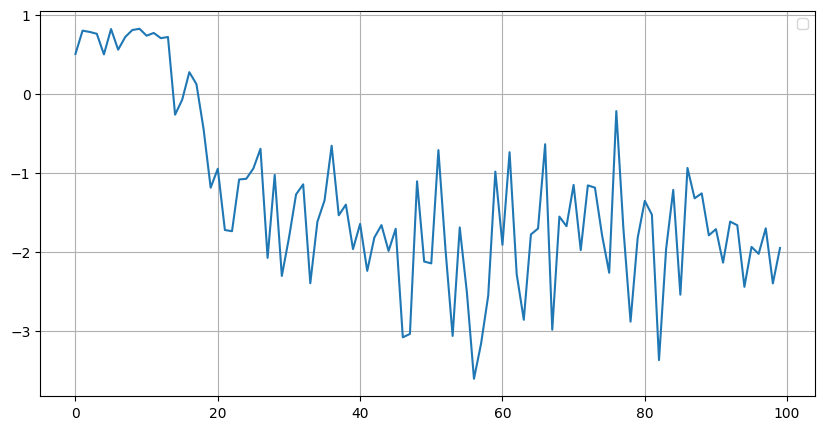

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0001, 'verbose': 0}


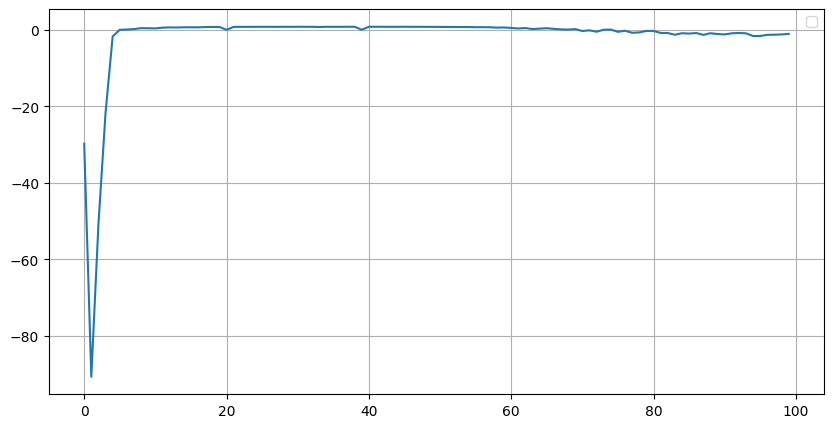

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}


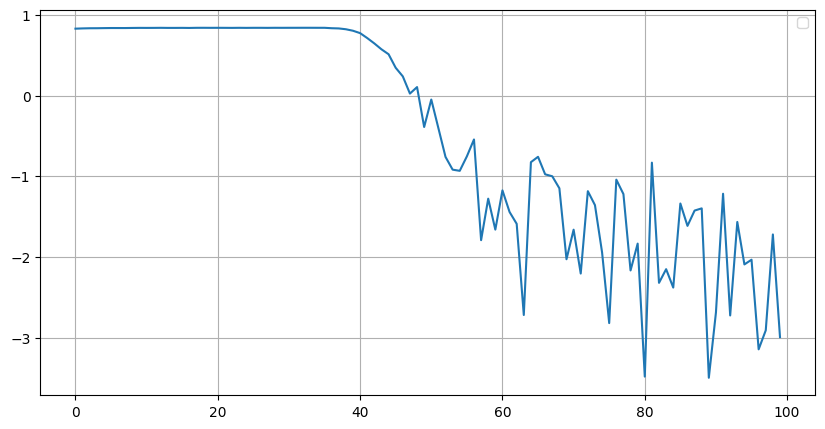

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}


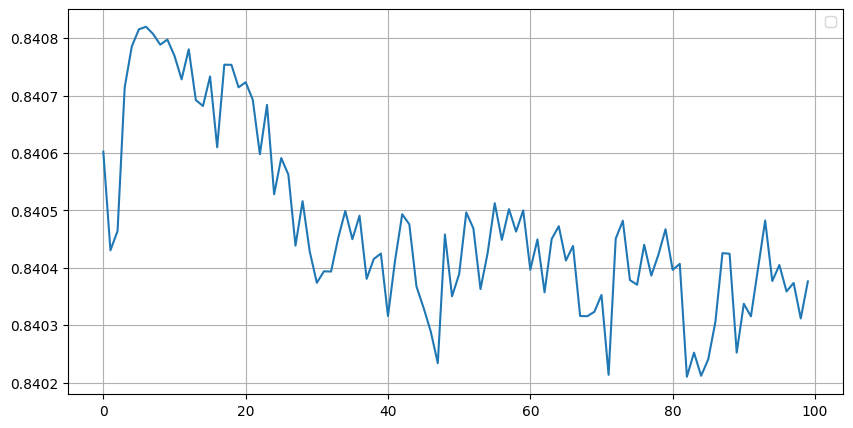

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}


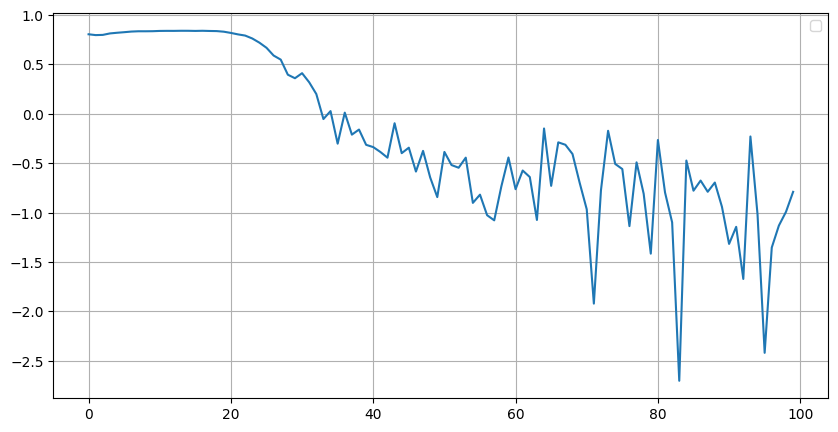

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0001, 'verbose': 0}


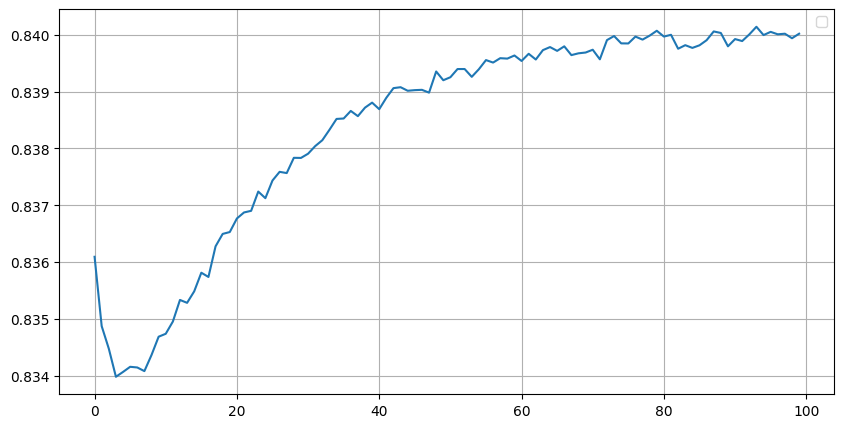

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0005, 'verbose': 0}


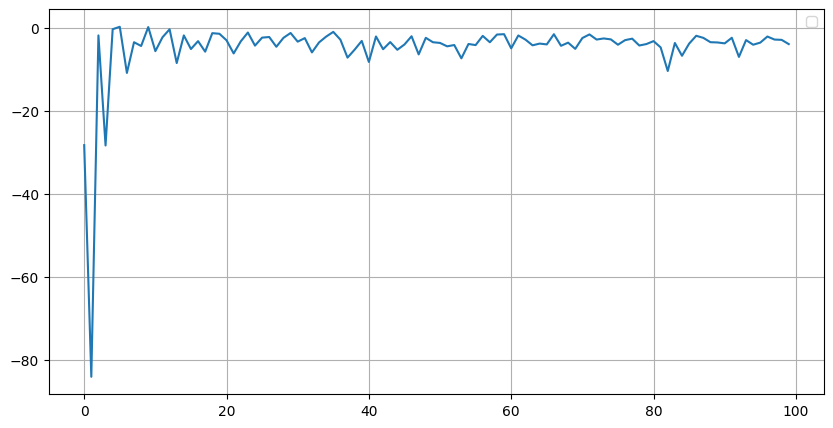

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


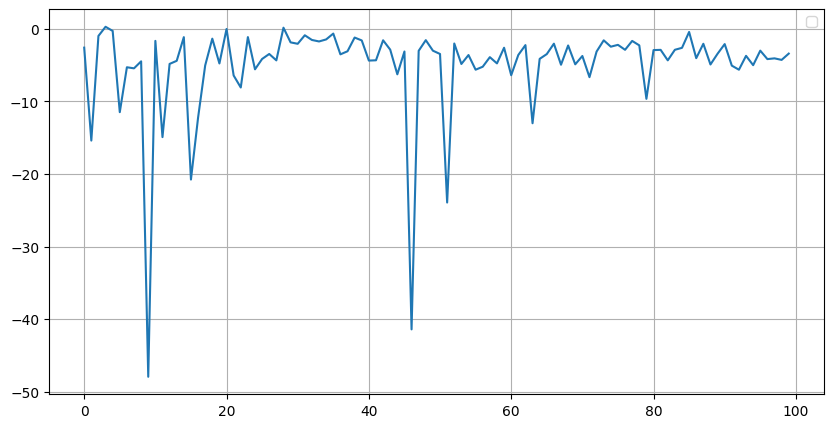

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0005, 'verbose': 0}


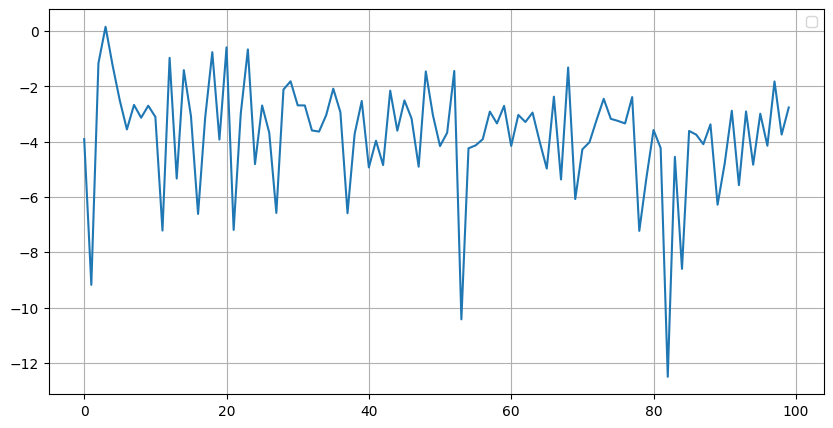

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0001, 'verbose': 0}


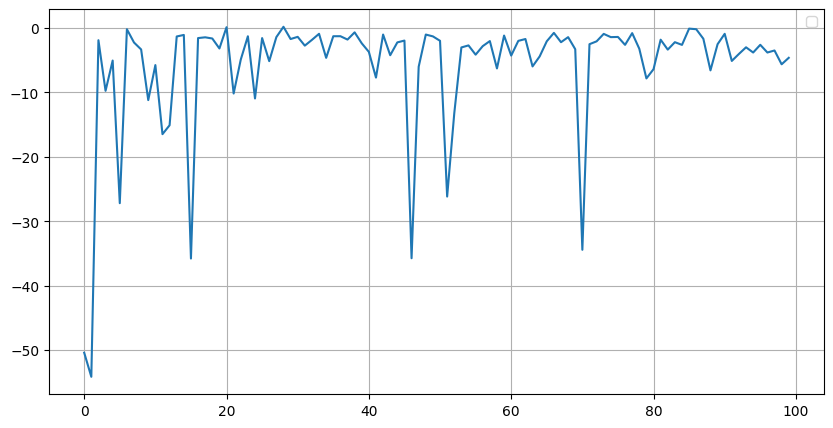

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}


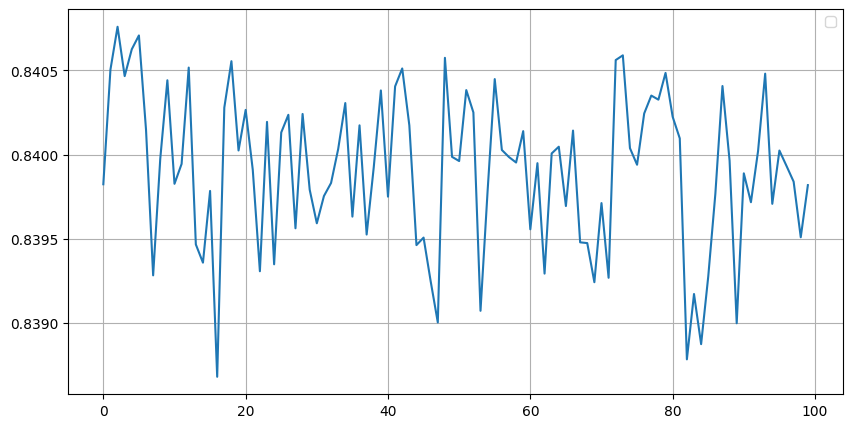

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}


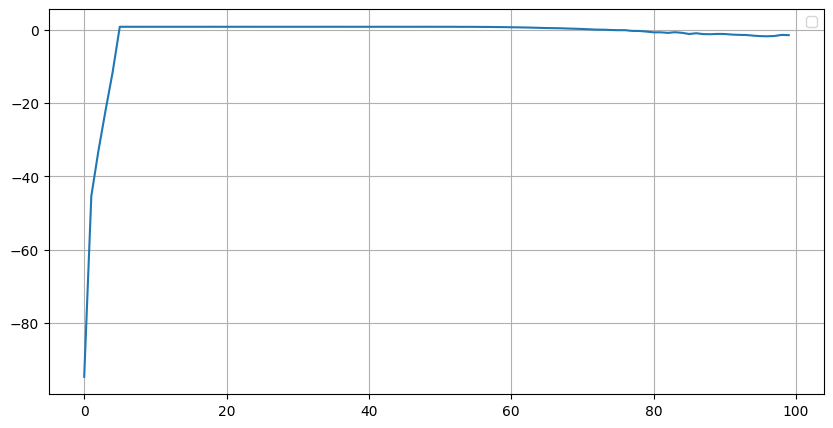

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}


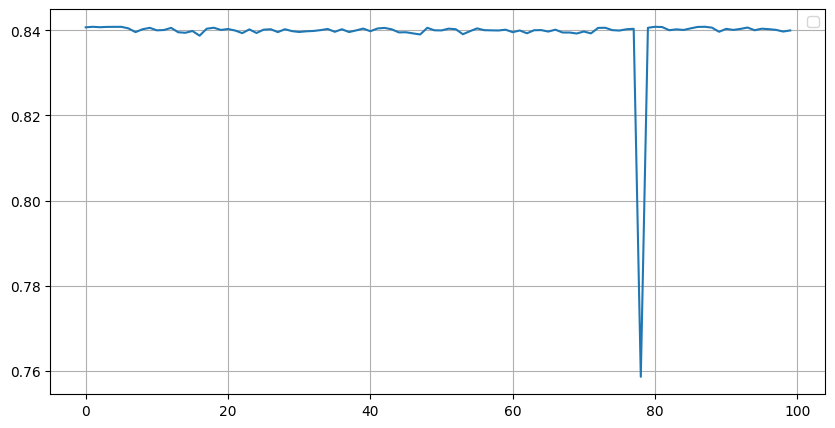

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0001, 'verbose': 0}


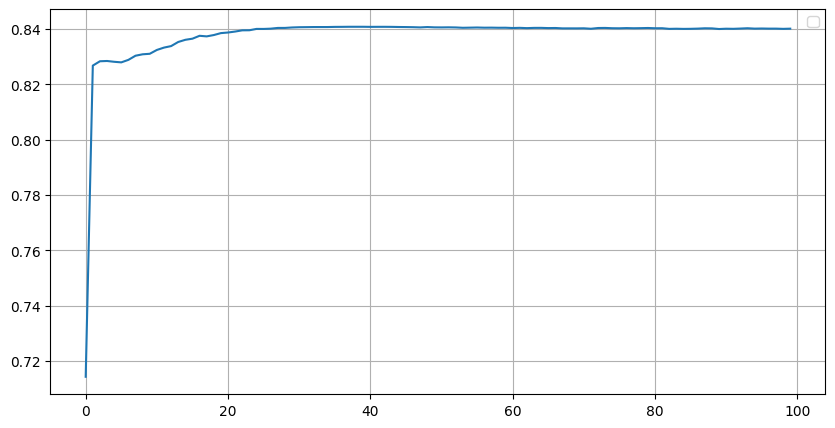

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0005, 'verbose': 0}


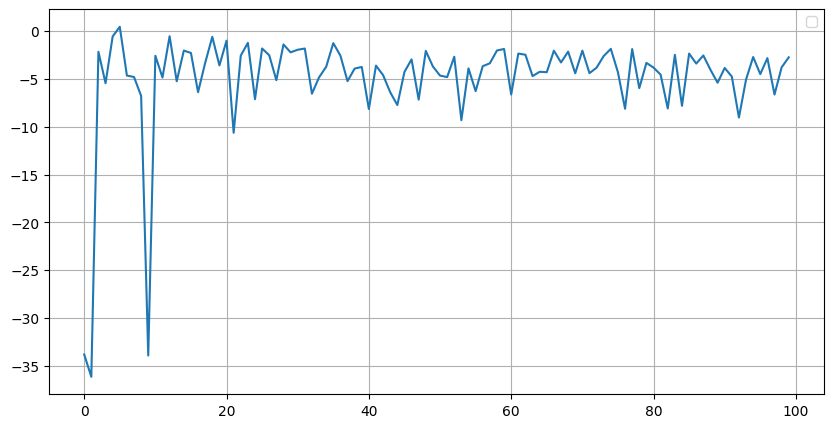

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


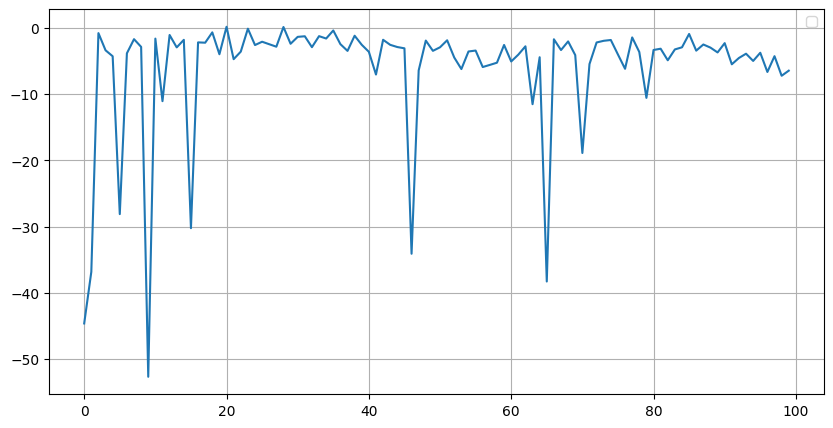

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0005, 'verbose': 0}


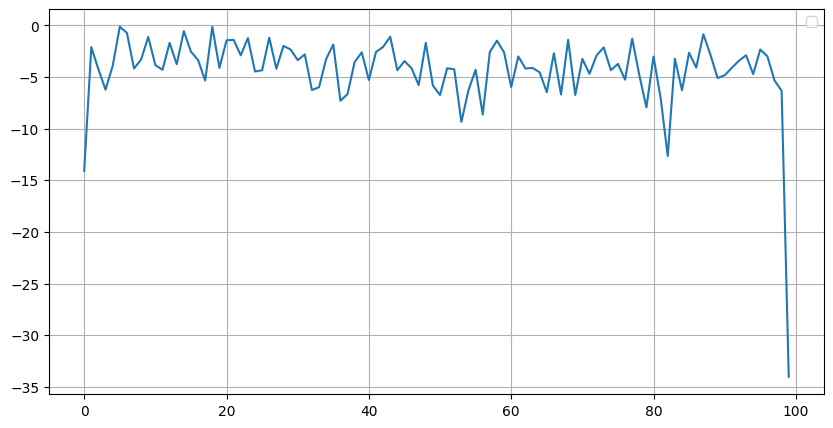

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [128, 64, 32, 16, 8], 'learning_rate': 0.0001, 'verbose': 0}


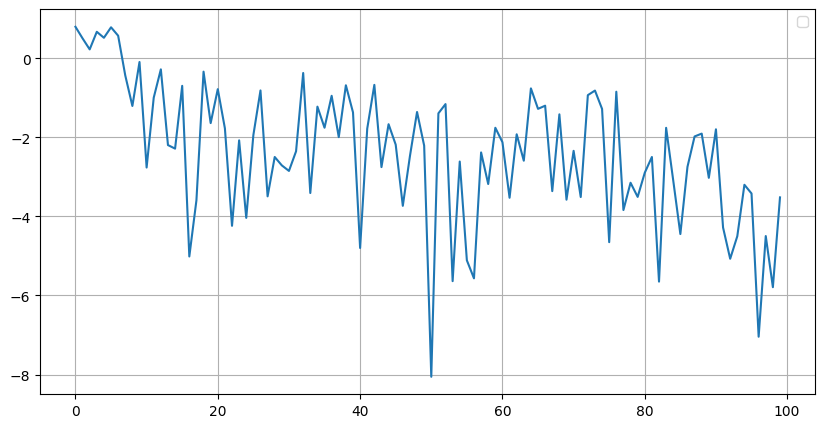

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}


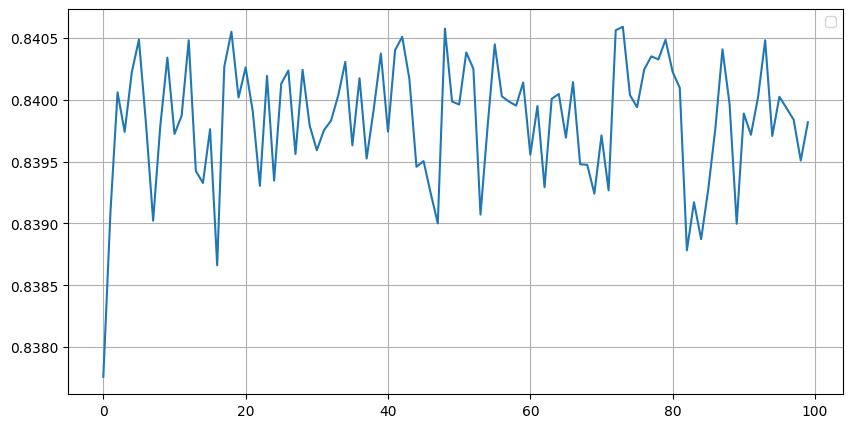

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}


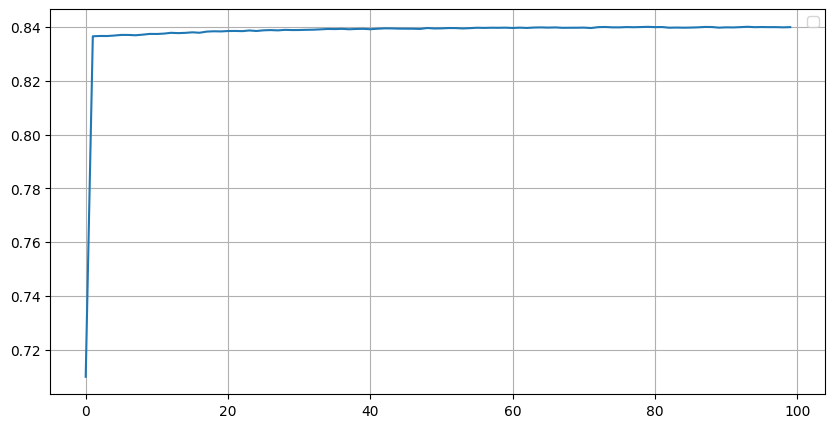

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}


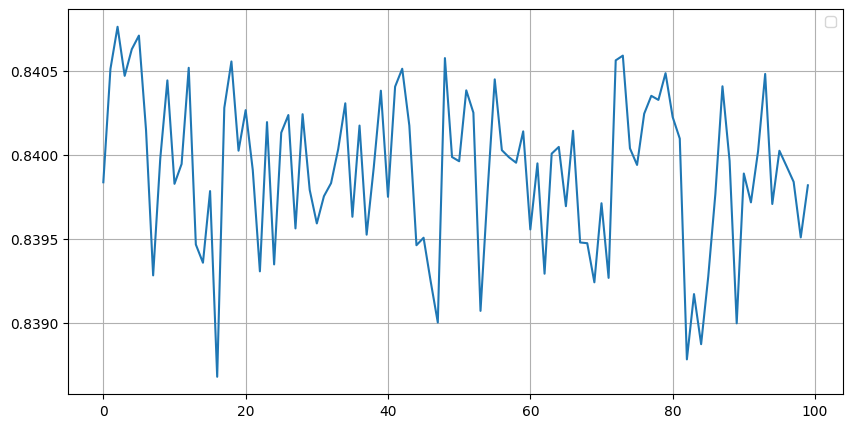

{'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.025, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0001, 'verbose': 0}


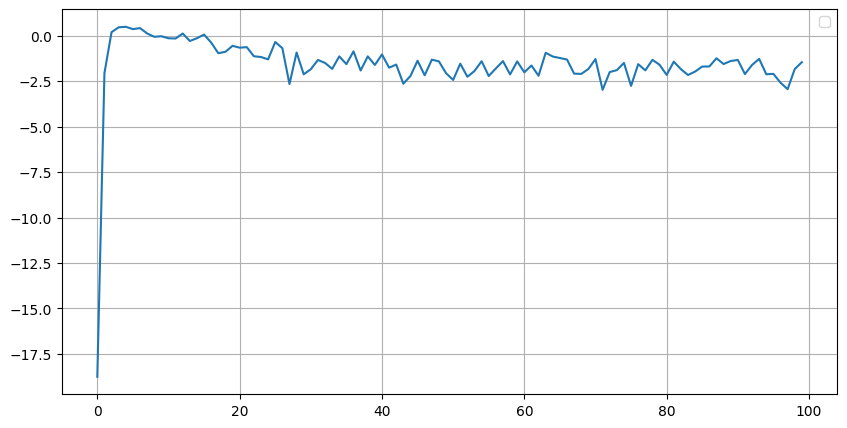

In [19]:
from sklearn.model_selection import ParameterGrid
import gc

best_score = float('-inf')
best_params = None

ultimate_best_score = float('-inf')
ultimate_best_params = None

history = []
ultimate_history = []

for params in ParameterGrid(smaller_param_grid):
    print(params)
    create_model(params['layers'], params['dropout'], params['learning_rate']).fit(
        X_train,
        y_train,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=params['verbose'],
        callbacks=params['callbacks'],
        class_weight=params['class_weight'],
    )
    score = racePerformanceCallback.score_history[-1]

    history.append({
        'params': params,
        'score': score,
    })
    ultimate_score = max(racePerformanceCallback.score_history)

    ultimate_history.append({
        'params': params,
        'score': ultimate_score,
    })

    if score > best_score:
        best_score = score
        best_params = params
    if ultimate_score > ultimate_best_score:
        ultimate_best_score = ultimate_score
        ultimate_best_params = params
    # Clear the Keras session and perform garbage collection
    keras.backend.clear_session()
    gc.collect()

In [20]:
print('Best score:', best_score)
print('Best params:', best_params)

print('Ultimate best score:', ultimate_best_score)
print('Ultimate best params:', ultimate_best_params)

Best score: 0.8408165513271012
Best params: {'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}
Ultimate best score: 0.8410555274493209
Ultimate best params: {'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}


In [27]:
#print the best params by sorting the history array
sorted_history = sorted(history, key=lambda x: x['score'], reverse=True)
for i in range(len(sorted_history)):
    print(sorted_history[i]['score'], sorted_history[i]['params'])

0.8408165513271012 {'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}
0.8407413793668556 {'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0001, 'verbose': 0}
0.8404676498445784 {'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}
0.8403763203503094 {'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at

In [28]:
sorted_ultimate_history = sorted(ultimate_history, key=lambda x: x['score'], reverse=True)
for i in range(len(sorted_ultimate_history)):
    print(sorted_ultimate_history[i]['score'], sorted_ultimate_history[i]['params'])

0.8410555274493209 {'batch_size': 512, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [256, 128, 64, 32, 16], 'learning_rate': 0.0001, 'verbose': 0}
0.8408356345476247 {'batch_size': 1024, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.4, 0.3, 0.2, 0, 0], 'epochs': 100, 'layers': [64, 16, 2], 'learning_rate': 0.0005, 'verbose': 0}
0.8408238860552462 {'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback object at 0x0000028AC0E41450>], 'class_weight': {0: 0.5146295823764566, 1: 17.588662790697676}, 'dropout': [0.05, 0, 0, 0, 0], 'epochs': 100, 'layers': [32, 8, 1], 'learning_rate': 0.0005, 'verbose': 0}
0.8408237684388492 {'batch_size': 256, 'callbacks': [<__main__.RacePerformanceMetricCallback

Epoch 1/10
60/60 [==============================] - 15s 245ms/step - loss: 1.4977 - balanced_accuracy_loss: 0.5003 - val_loss: 1.1434 - val_balanced_accuracy_loss: 0.5012
Epoch 2/10
60/60 [==============================] - 15s 246ms/step - loss: 0.8703 - balanced_accuracy_loss: 0.5102 - val_loss: 1.0287 - val_balanced_accuracy_loss: 0.5085
Epoch 3/10
60/60 [==============================] - 15s 248ms/step - loss: 0.8390 - balanced_accuracy_loss: 0.5024 - val_loss: 0.6175 - val_balanced_accuracy_loss: 0.5035
Epoch 4/10
60/60 [==============================] - 15s 246ms/step - loss: 0.7566 - balanced_accuracy_loss: 0.5080 - val_loss: 0.9556 - val_balanced_accuracy_loss: 0.5171
Epoch 5/10
60/60 [==============================] - 14s 244ms/step - loss: 0.7242 - balanced_accuracy_loss: 0.5131 - val_loss: 0.6290 - val_balanced_accuracy_loss: 0.5245
Epoch 6/10
60/60 [==============================] - 15s 246ms/step - loss: 0.7010 - balanced_accuracy_loss: 0.5300 - val_loss: 0.6001 - val_balan

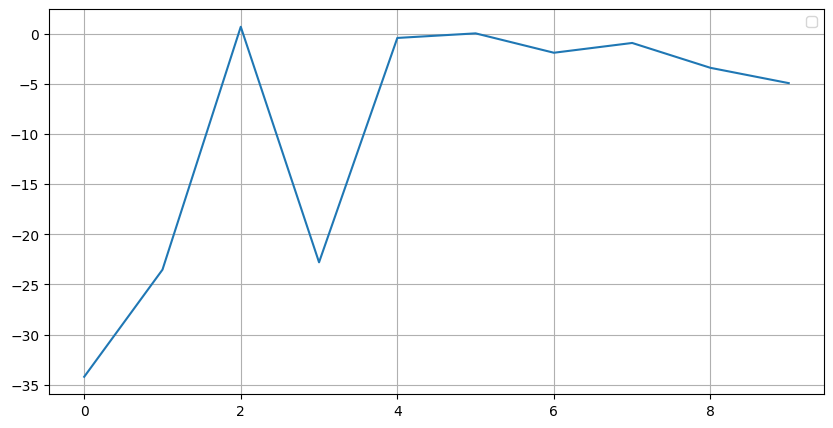

In [545]:


hist = model.fit(
    X_train, y_train, 
    epochs=10,
    batch_size=1024,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[racePerformanceCallback],
)

In [53]:
y_pred = model.predict(X_test)

510/510 [==============================] - 1s 1ms/step


In [54]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test, y_pred.round()))

[[11390  4417]
 [   57   435]]


              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84     15807
         1.0       0.09      0.88      0.16       492

    accuracy                           0.73     16299
   macro avg       0.54      0.80      0.50     16299
weighted avg       0.97      0.73      0.82     16299



In [55]:
import pickle
# Save model
models_dir = 'models/nn_complexe_big_batch_size_lr05drop2'
os.makedirs(models_dir, exist_ok=True)
model.save(os.path.join(models_dir, 'model.h5'))
encoder_path = os.path.join(models_dir, 'encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(encoder, f)

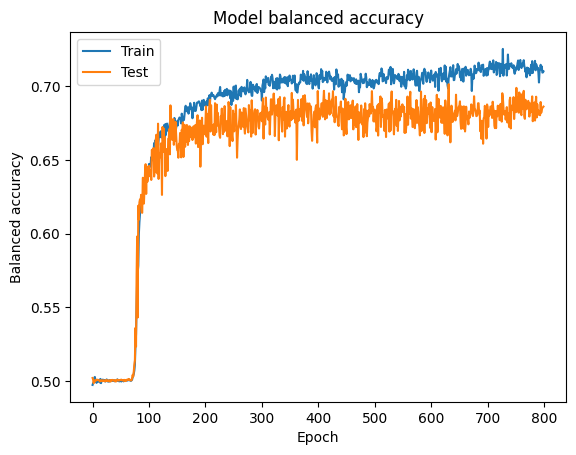

In [56]:
import matplotlib.pyplot as plt

plt.plot(hist.history['balanced_accuracy_loss'])
plt.plot(hist.history['val_balanced_accuracy_loss'])
plt.title('Model balanced accuracy')
plt.ylabel('Balanced accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(models_dir, 'balanced_accuracy.svg'), format='svg')
plt.show()